In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import gurobipy

In [2]:
def Make_MSS_WoL(Stages, Initial_state, Gradient, Costs, WoL):
    
    """
    Stages = Int
    
    Initial_state = [Houses, Gatherers, Workers, Resources]
    Gradient      = [army/barracks, buildigs/worker, peasants/houses, supply/houses, resources/gatherer]
    Costs         = [0, crystal_costs]
    costs         = [Archers, Barracks, Gatherers, Houses, Knights, Workers]
    WoL           = [RawVespene vs RawCrystals, Archers Impact vs Knights Impact]
                    """
    
    # Resources
    Crystals               = cvx.Variable(Stages, name = 'Crystals')
    Vespene                = cvx.Variable(Stages, name = 'Vespene')
    Raw_Crystal_production = cvx.Variable(Stages, name = 'Raw Crystal Production')
    Raw_Vespene_production = cvx.Variable(Stages, name = 'Raw Vespene Production')
    
    # Peasants
    Workers    = cvx.Variable(Stages, name = 'Workers')
    Gatherers  = cvx.Variable(Stages, name = 'Gatherers')
    
    # Structures
    Houses     = cvx.Variable(Stages, name = 'Houses')
    Barracks   = cvx.Variable(Stages, name = 'Barracks')
    
    # Army
    Army       = cvx.Variable(Stages, name = 'Army')
    Archers    = cvx.Variable(Stages, name = 'Archers')
    Knights    = cvx.Variable(Stages, name = 'Knights')
    
    A  = cvx.Variable(Stages-1, name = 'Archers Production')
    B  = cvx.Variable(Stages-1, name = 'Barracks Production')
    C  = cvx.Variable(Stages-1, name = 'Crystal Production')
    G  = cvx.Variable(Stages-1, name = 'Gatherers Production')
    H  = cvx.Variable(Stages-1, name = 'Houses Production')
    K  = cvx.Variable(Stages-1, name = 'Knights Production')
    V  = cvx.Variable(Stages-1, name = 'Vespene Production')
    W  = cvx.Variable(Stages-1, name = 'Workers Production')
    
    initial_gatherers = cvx.Parameter()
    initial_houses    = cvx.Parameter()
    initial_workers   = cvx.Parameter()
    initial_crystals  = cvx.Parameter()
    initial_vespene   = cvx.Parameter()
    
    army_barracks      = cvx.Parameter()
    buildings_workers  = cvx.Parameter()
    peasants_houses    = cvx.Parameter()
    army_building      = cvx.Parameter()
    supplies_houses    = cvx.Parameter()
    resources_gatherer = cvx.Parameter()
    
    # WoL ( Crystals vs Vespene)
    cv, ak = WoL
    
    # Costs in Vespene
    custo_vespene_archers   = cvx.Parameter()
    custo_vespene_barracks  = cvx.Parameter()
    custo_vespene_gatherers = cvx.Parameter()
    custo_vespene_houses    = cvx.Parameter()
    custo_vespene_knights   = cvx.Parameter()
    custo_vespene_workers   = cvx.Parameter()

    # Costs in Crystals
    custo_crystal_archers   = cvx.Parameter()
    custo_crystal_barracks  = cvx.Parameter()
    custo_crystal_gatherers = cvx.Parameter()
    custo_crystal_houses    = cvx.Parameter()
    custo_crystal_knights   = cvx.Parameter()
    custo_crystal_workers   = cvx.Parameter()
    
    # Initial State
    initial_houses, initial_gatherers, initial_workers, initial_vespene, initial_crystals = Initial_state
    # Gradient
    army_barracks, buildings_workers, peasants_houses, supplies_houses, resources_gatherer  = Gradient
    # Costs
    crystal_costs, vespene_costs = Costs
    custo_vespene_archers, custo_vespene_barracks, custo_vespene_gatherers, custo_vespene_houses, custo_vespene_knights, custo_vespene_workers = vespene_costs
    custo_crystal_archers, custo_crystal_barracks, custo_crystal_gatherers, custo_crystal_houses, custo_crystal_knights, custo_crystal_workers = crystal_costs
    
    
    print('Worker Costs = ' + str(custo_crystal_workers))
    
    Constraints = [Archers[0]   == 0,
                   Barracks[0]  == 0,
                   Gatherers[0] == initial_gatherers,
                   Houses[0]    == initial_houses,
                   Knights[0]   == 0,
                   Workers[0]   == initial_workers,
                   Army[0]      == 0,
                   Vespene[0]   == initial_vespene,
                   Crystals[0]  == initial_crystals,

                   A  >= 0,
                   B  >= 0,
                   G  >= 0,
                   H  >= 0,
                   K  >= 0,
                   W  >= 0]

    for i in range(Stages-1):

        Constraints.append(A[i] == Archers[i+1]   - Archers[i])
        Constraints.append(B[i] == Barracks[i+1]  - Barracks[i])
        Constraints.append(C[i] == Crystals[i+1]  - Crystals[i])
        Constraints.append(G[i] == Gatherers[i+1] - Gatherers[i])
        Constraints.append(H[i] == Houses[i+1]    - Houses[i])
        Constraints.append(K[i] == Knights[i+1]   - Knights[i])
        Constraints.append(V[i] == Vespene[i+1]   - Vespene[i])
        Constraints.append(W[i] == Workers[i+1]   - Workers[i])



        Constraints.append(A[i]  + K[i] <= army_barracks*Barracks[i])
        Constraints.append(B[i]  + H[i] <= buildings_workers*Workers[i])
        Constraints.append(G[i]  + W[i] <= peasants_houses*Houses[i])
        Constraints.append(Raw_Crystal_production[i] + cv*Raw_Vespene_production[i] == resources_gatherer*Gatherers[i])

        Constraints.append(Army[i+1] == Archers[i+1] + ak*Knights[i+1])
        Constraints.append(Army[i+1] 
                           + Gatherers[i+1] 
                           + Workers[i+1] <= Houses[i+1]*supplies_houses)

        Constraints.append(C[i] == Raw_Crystal_production[i]
                           - custo_crystal_archers*A[i] 
                           - custo_crystal_barracks*B[i]
                           - custo_crystal_gatherers*G[i]
                           - custo_crystal_houses*H[i]
                           - custo_crystal_knights*K[i]
                           - custo_crystal_workers*W[i])

        Constraints.append(V[i] == Raw_Vespene_production[i]
                           - custo_vespene_archers*A[i] 
                           - custo_vespene_knights*K[i])

        Constraints.append(Crystals[i]  >=  custo_crystal_archers*A[i] 
                           + custo_crystal_barracks*B[i]
                           + custo_crystal_gatherers*G[i]
                           + custo_crystal_houses*H[i]
                           + custo_crystal_knights*K[i]
                           + custo_crystal_workers*W[i])

        Constraints.append(Vespene[i]  >=  custo_vespene_archers*A[i]
                           + custo_vespene_knights*K[i])

        Constraints.append(Raw_Vespene_production[i] >= 0)
        Constraints.append(Raw_Crystal_production[i] >= 0)

    F_obj = cvx.Maximize(Army[-1])
    
    return cvx.Problem(F_obj, Constraints)

# MSS WOL PLOT


In [3]:
def MSS_WoL_plot(Stages, problem, save = False, Title = False, figname = False):

    Army, Archers, Barracks, Gatherers, Houses, Knights, Workers, Vespene, Crystals,*f, RGP, RCP = problem.variables()
    
################ Adjustments #########################################

    plt.figure(figsize=(12,8))
    plt.subplots_adjust(left=0.05, right=0.95, bottom = 0.4, top = 0.9,hspace = 0.4)
    
######################  First Plot  ##################################

    plt.subplot(231)
#    plt.plot(Archers.value[:Stages],'--*', label=Archers.name())
    plt.plot(Barracks.value[:Stages],'--*', label=Barracks.name())
    plt.plot(Houses.value[:Stages],'--*', label=Houses.name())
#    plt.plot(Knights.value[:Stages],'o--', label=Knights.name())
    plt.plot(Gatherers.value[:Stages], label=Gatherers.name())
    plt.plot(Workers.value[:Stages], label=Workers.name())
    plt.plot(Crystals.value[:Stages], label = Crystals.name())
    plt.plot(Vespene.value[:Stages], label = 'Vespene')
    if Title:
        plt.title(Title)
    else:
        plt.title(str(Stages) + ' Estágios')
    plt.legend()
    plt.grid(True)
    
######################  Second Plot  ##################################

    plt.subplot(232)
    plt.plot(Archers.value[:Stages] + Knights.value[:Stages],'--*', label='Army')
    plt.plot(Gatherers.value[:Stages] + Workers.value[:Stages],'o--', label='Peasants')
    plt.plot(Crystals.value[:Stages] + Vespene.value[:Stages], label='Resources')
    plt.plot(Barracks.value[:Stages] + Houses.value[:Stages], label='Buildings')
    if Title:
        plt.title(Title + ' - Logscale')
    else:
        plt.title(str(Stages) + ' Estágios - Logscale')
    plt.yscale('symlog')
    plt.grid(True)

    plt.legend()


######################  Third Plot  ##################################

    plt.subplot(233)
    plt.plot(Crystals.value[:Stages] + Vespene.value[:Stages], label='Resources')
    plt.plot(Archers.value[:Stages]  + Knights.value[:Stages],'--*', label='Army')
    plt.legend()
    plt.yscale('symlog', linthreshy=0.015)
    plt.grid(True)
    plt.title('Army and Resources')
    plt.tight_layout()
    
    
    ######################  Fourth Plot  ##################################

    plt.subplot(234)
    plt.plot(Archers.value[:Stages],'--*', label=Archers.name())
#    plt.plot(Barracks.value[:Stages],'--*', label=Barracks.name())
#    plt.plot(Houses.value[:Stages],'--*', label=Houses.name())
    plt.plot(Knights.value[:Stages],'o--', label=Knights.name())
#    plt.plot(Gatherers.value[:Stages], label=Gatherers.name())
#    plt.plot(Workers.value[:Stages], label=Workers.name())
    plt.plot(Crystals.value[:Stages], label = Crystals.name())
    plt.plot(Vespene.value[:Stages], label = 'Vespene')
#     if Title:
#         plt.title(Title)
#     else:
#         plt.title(str(Stages) + ' Estágios')
    plt.legend()
    plt.xlabel('Stages')
    plt.grid(True)    
    
######################  Fith Plot  ##################################

    plt.subplot(235)
#    plt.plot(Archers.value[:Stages] + Knights.value[:Stages],'--*', label='Army')
#    plt.plot(Gatherers.value[:Stages] + Workers.value[:Stages],'o--', label='Peasants')
    plt.plot(Crystals.value[:Stages] + Vespene.value[:Stages], label='Resources')
    plt.plot(Barracks.value[:Stages] + Houses.value[:Stages], label='Buildings')
#     if Title:
#         plt.title(Title + ' 2- Logscale')
#     else:
#         plt.title(str(Stages) + '2 Estágios - Logscale')
    plt.yscale('symlog')
    plt.xlabel('Stages')
    plt.grid(True)

    plt.legend()
    
        
######################  Sixth Plot  ##################################

    plt.subplot(236)
    plt.plot(Archers.value[:Stages] + Knights.value[:Stages],'--*', label='Army')
#    plt.plot(Gatherers.value[:Stages] + Workers.value[:Stages],'o--', label='Peasants')
#    plt.plot(Crystals.value[:Stages] + Vespene.value[:Stages], label='Resources')
    plt.plot(Barracks.value[:Stages] + Houses.value[:Stages], label='Buildings')
#     if Title:
#         plt.title(Title + ' 2 - Logscale')
#     else:
#         plt.title(str(Stages) + ' 2 Estágios - Logscale')
    plt.yscale('symlog')
    plt.xlabel('Stages')
    plt.grid(True)

    plt.legend()


    
    plt.show()
#####################################################################
    #plt.plot(Army.value[:Stages], label='')
    #plt.plot(Max_supply.value[:Stages], label='')
    #plt.plot(B.value[:Stages], label='')
    #plt.plot(G.value[:Stages], label='')
    

    if save:
        if figname:
            
            plt.savefig(figname, bbox_inches = 'tight',pad_inches = 0)
        else:
            mnum = np.random.rand() + 10*sum(initial_state)
            plt.savefig(str(Stages)+'_Estagios_'+str(mnum), bbox_inches = 'tight', pad_inches = 0)

In [4]:
stages        = 15
initial_cond  = [1,1,0,0,0]
productions   = [2,2,2,2,2]
costs_c       = [1,1,1,1,1,1]
costs_v       = [1,0,0,0,2,0] # Archer, Knights

In [5]:
problem = Make_MSS_WoL(Stages = stages, Initial_state = initial_cond, Gradient = productions ,Costs = [costs_c, costs_v], WoL = [2,1.8])

Worker Costs = 1


In [6]:
%time problem.solve(solver = 'GUROBI')

Academic license - for non-commercial use only
Wall time: 363 ms


293.4069868733291

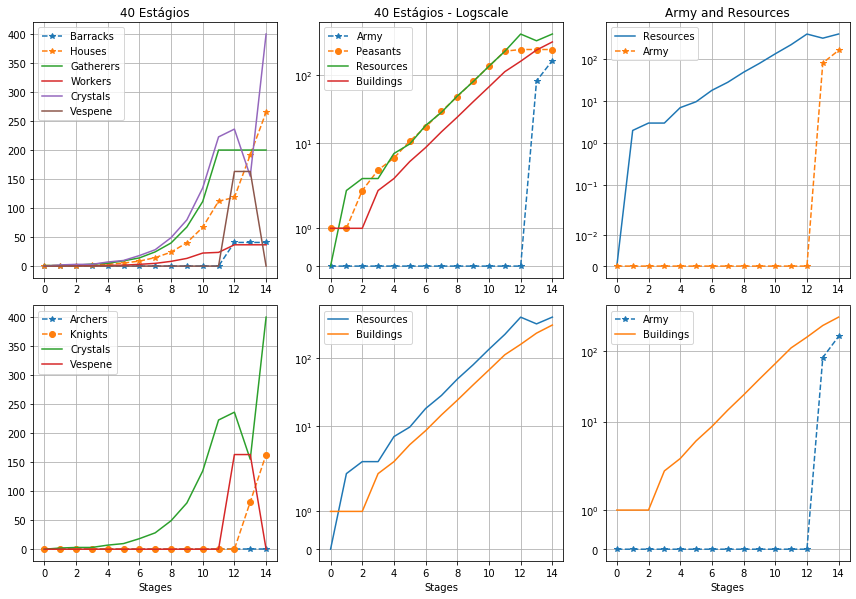

In [7]:
MSS_WoL_plot(40,problem)

# MIMSS_WoL

In [119]:
def MIMSS_WoL(Stages, Initial_state, Gradient, Costs, WoL):
    
    """
    Stages = Int
    
    Initial_state = [Houses, Gatherers, Workers, Resources]
    Gradient      = [army/barracks, buildigs/worker, peasants/houses, supply/houses, resources/gatherer]
    Costs         = [vespene_costs, crystal_costs]
    costs         = [Archers, Barracks, Gatherers, Houses, Knights, Workers]
    WoL           = [RawVespene vs RawCrystals, Archers Impact vs Knights Impact]
                    """
    
    # Resources
    Crystals               = cvx.Variable(Stages, name = 'Crystals', integer = True)
    Vespene                = cvx.Variable(Stages, name = 'Vespene', integer = True)
    Raw_Crystal_production = cvx.Variable(Stages, name = 'Raw Crystal Production', integer = True)
    Raw_Vespene_production = cvx.Variable(Stages, name = 'Raw Vespene Production', integer = True)
    
    # Peasants
    Workers    = cvx.Variable(Stages, name = 'Workers', integer = True)
    Gatherers  = cvx.Variable(Stages, name = 'Gatherers', integer = True)
    
    # Structures
    Houses     = cvx.Variable(Stages, name = 'Houses', integer = True)
    Barracks   = cvx.Variable(Stages, name = 'Barracks', integer = True)
    
    # Army
    Army       = cvx.Variable(Stages, name = 'Army', integer = True)
    Archers    = cvx.Variable(Stages, name = 'Archers', integer = True)
    Knights    = cvx.Variable(Stages, name = 'Knights', integer = True)
    
    A  = cvx.Variable(Stages-1, name = 'Archers Production')
    B  = cvx.Variable(Stages-1, name = 'Barracks Production')
    C  = cvx.Variable(Stages-1, name = 'Crystal Production')
    G  = cvx.Variable(Stages-1, name = 'Gatherers Production')
    H  = cvx.Variable(Stages-1, name = 'Houses Production')
    K  = cvx.Variable(Stages-1, name = 'Knights Production')
    V  = cvx.Variable(Stages-1, name = 'Vespene Production')
    W  = cvx.Variable(Stages-1, name = 'Workers Production')
    
    initial_gatherers = cvx.Parameter()
    initial_houses    = cvx.Parameter()
    initial_workers   = cvx.Parameter()
    initial_crystals  = cvx.Parameter()
    initial_vespene   = cvx.Parameter()
    
    army_barracks      = cvx.Parameter()
    buildings_workers  = cvx.Parameter()
    peasants_houses    = cvx.Parameter()
    army_building      = cvx.Parameter()
    supplies_houses    = cvx.Parameter()
    resources_gatherer = cvx.Parameter()
    
    # WoL ( Crystals vs Vespene)
    cv, ak = WoL
    
    # Costs in Vespene
    custo_vespene_archers   = cvx.Parameter()
    custo_vespene_barracks  = cvx.Parameter()
    custo_vespene_gatherers = cvx.Parameter()
    custo_vespene_houses    = cvx.Parameter()
    custo_vespene_knights   = cvx.Parameter()
    custo_vespene_workers   = cvx.Parameter()

    # Costs in Crystals
    custo_crystal_archers   = cvx.Parameter()
    custo_crystal_barracks  = cvx.Parameter()
    custo_crystal_gatherers = cvx.Parameter()
    custo_crystal_houses    = cvx.Parameter()
    custo_crystal_knights   = cvx.Parameter()
    custo_crystal_workers   = cvx.Parameter()
    
    # Initial State
    initial_houses, initial_gatherers, initial_workers, initial_vespene, initial_crystals = Initial_state
    # Gradient
    army_barracks, buildings_workers, peasants_houses, supplies_houses, resources_gatherer  = Gradient
    # Costs
    crystal_costs, vespene_costs = Costs
    custo_vespene_archers, custo_vespene_barracks, custo_vespene_gatherers, custo_vespene_houses, custo_vespene_knights, custo_vespene_workers = vespene_costs
    custo_crystal_archers, custo_crystal_barracks, custo_crystal_gatherers, custo_crystal_houses, custo_crystal_knights, custo_crystal_workers = crystal_costs
    
    
    print('Worker Costs = ' + str(custo_crystal_workers))
    
    Constraints = [Archers[0]   == 0,
                   Barracks[0]  == 0,
                   Gatherers[0] == initial_gatherers,
                   Houses[0]    == initial_houses,
                   Knights[0]   == 0,
                   Workers[0]   == initial_workers,
                   Army[0]      == 0,
                   Vespene[0]   == initial_vespene,
                   Crystals[0]  == initial_crystals,

                   A  >= 0,
                   B  >= 0,
                   G  >= 0,
                   H  >= 0,
                   K  >= 0,
                   W  >= 0]

    for i in range(Stages-1):

        Constraints.append(A[i] == Archers[i+1]   - Archers[i])
        Constraints.append(B[i] == Barracks[i+1]  - Barracks[i])
        Constraints.append(C[i] == Crystals[i+1]  - Crystals[i])
        Constraints.append(G[i] == Gatherers[i+1] - Gatherers[i])
        Constraints.append(H[i] == Houses[i+1]    - Houses[i])
        Constraints.append(K[i] == Knights[i+1]   - Knights[i])
        Constraints.append(V[i] == Vespene[i+1]   - Vespene[i])
        Constraints.append(W[i] == Workers[i+1]   - Workers[i])



        Constraints.append(A[i]  + K[i] <= army_barracks*Barracks[i])
        Constraints.append(B[i]  + H[i] <= buildings_workers*Workers[i])
        Constraints.append(G[i]  + W[i] <= peasants_houses*Houses[i])
        Constraints.append(Raw_Crystal_production[i] + cv*Raw_Vespene_production[i] == resources_gatherer*Gatherers[i])

        Constraints.append(Army[i+1] == Archers[i+1] + ak*Knights[i+1])
        Constraints.append(Army[i+1] 
                           + Gatherers[i+1] 
                           + Workers[i+1] <= Houses[i+1]*supplies_houses)

        Constraints.append(C[i] == Raw_Crystal_production[i]
                           - custo_crystal_archers*A[i] 
                           - custo_crystal_barracks*B[i]
                           - custo_crystal_gatherers*G[i]
                           - custo_crystal_houses*H[i]
                           - custo_crystal_knights*K[i]
                           - custo_crystal_workers*W[i])

        Constraints.append(V[i] == Raw_Vespene_production[i]
                           - custo_vespene_archers*A[i] 
                           - custo_vespene_knights*K[i])

        Constraints.append(Crystals[i]  >=  custo_crystal_archers*A[i] 
                           + custo_crystal_barracks*B[i]
                           + custo_crystal_gatherers*G[i]
                           + custo_crystal_houses*H[i]
                           + custo_crystal_knights*K[i]
                           + custo_crystal_workers*W[i])

        Constraints.append(Vespene[i]  >=  custo_vespene_archers*A[i]
                           + custo_vespene_knights*K[i])

        Constraints.append(Raw_Vespene_production[i] >= 0)
        Constraints.append(Raw_Crystal_production[i] >= 0)

    F_obj = cvx.Maximize(Army[-1])
    
    return cvx.Problem(F_obj, Constraints)

In [120]:
int_problem = MIMSS_WoL(Stages = stages, Initial_state = initial_cond, Gradient = productions ,Costs = [costs_c, costs_v], WoL = [2,1.8])

Worker Costs = 1


In [121]:
int_problem.solve(solver='GUROBI')

246.0

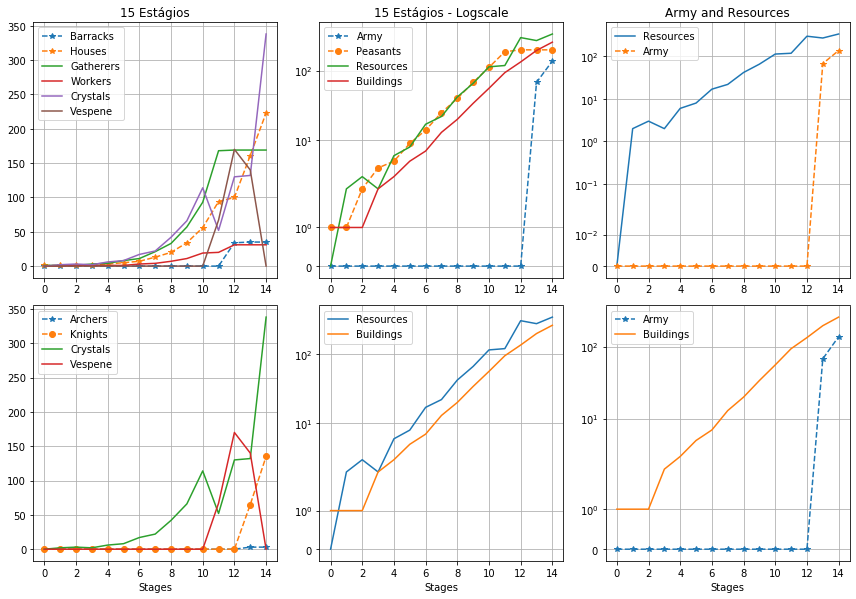

In [122]:
MSS_WoL_plot(stages,int_problem)